## Project Title: 
### Customer Insights and Benefit Prediction for Sure Tomorrow Insurance

Project Overview:

We will explore machine learning techniques to solve key business problems for the Sure Tomorrow insurance company. The project will address the following:

Customer Similarity: We'll develop a method to find customers who are similar to a given customer, helping agents target marketing campaigns effectively.

Benefit Prediction: We'll create a predictive model to determine whether a new customer is likely to receive an insurance benefit, comparing its performance against a baseline (dummy) model.

Insurance Benefits Prediction: A linear regression model will predict the number of benefits a customer might receive, based on features like age, salary, and family members.

Data Protection: We'll implement data obfuscation techniques to protect customers' personal information while ensuring that model performance is not compromised.

The dataset includes features like gender, age, salary, and family members, with the target variable being the number of benefits received in the last five years.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sklearn.metrics
import sklearn.neighbors

from plotly.subplots import make_subplots
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from scipy.spatial import distance
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

display(df)

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4215,1,24.0,48100.0,2,0
3884,0,26.0,48400.0,3,0
4686,0,25.0,34800.0,1,0
2140,1,36.0,37700.0,1,0
883,0,21.0,39400.0,1,0
2409,1,20.0,46700.0,0,0
2700,1,26.0,46800.0,2,0
3964,1,24.0,40600.0,1,0
4886,1,38.0,26900.0,2,0
2301,1,40.0,55500.0,0,0


In [5]:
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


(5000, 5)

In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('string').str.split('.').str[0]
df['age'] = df['age'].apply(np.int64)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
df.describe().T
# Does everything look okay?

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
income,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
family_members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
insurance_benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


<b> Looking at the descriptive statistics, here’s an overview of what the data reveals: </b>

<b> gender: </b><br>
    Mean is close to 0.5, suggesting a nearly equal distribution between the two gender categories (assuming 0 = one gender, 1 = another).<br>
    Data appears binary, which is expected for a gender column.<br>
    No apparent issues here.

<b> age: </b><br>
    The minimum age is 18, and the maximum is 65, which seems reasonable for an insurance dataset.<br>
    The mean age is ~30.95, and the distribution between the 25th and 75th percentiles (24 to 37 years) shows a reasonable spread.<br>
    No extreme values or missing data are present.

<b> income: </b><br>
    The income values range from 5,300 to 79,000 with a mean of ~39,916.<br>
    The range looks plausible, but we should investigate the lower-income tail further (e.g., incomes close to 5,300).

<b> family_members: </b><br>
    The number of family members ranges from 0 to 6, with an average of 1.19.<br>
    No glaring issues, although we might need to confirm the legitimacy of cases where there are 0 family members.

<b> insurance_benefits: </b><br>
    This column (the target variable) has a mean of 0.148, indicating that most customers receive no benefits.<br>
    The maximum value is 5, which might represent outliers and could require closer examination.

<b> Conclusion: </b><br>

Overall, the data looks clean at first glance, with no immediate issues like missing or extreme values. However, it might be worth conducting further checks for outliers or unusual patterns in income and family_members.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

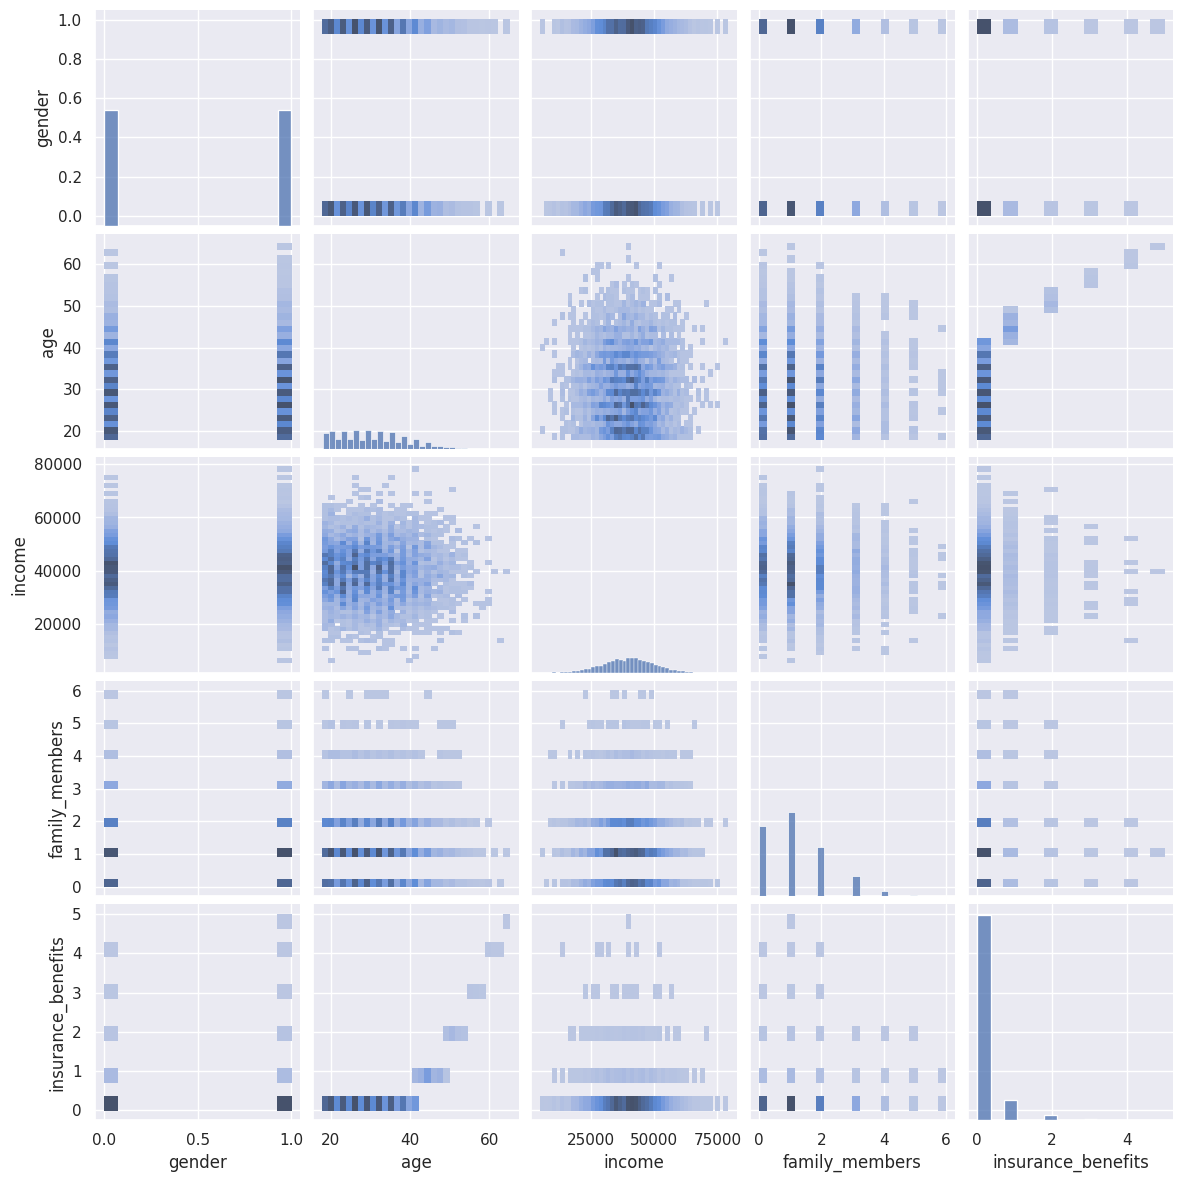

In [9]:
sns.set_theme()
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

In [10]:
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.002074,0.014910,-0.008991,0.010140
age,0.002074,1.000000,-0.019093,-0.006692,0.651030
income,0.014910,-0.019093,1.000000,-0.030296,-0.014963
family_members,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
insurance_benefits,0.010140,0.651030,-0.014963,-0.036290,1.000000


In [11]:
df.nunique()

gender                  2
age                    46
income                524
family_members          7
insurance_benefits      6
dtype: int64

In [12]:
df.duplicated().sum()

153

In [13]:
df.isnull().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Lasso for feature selection

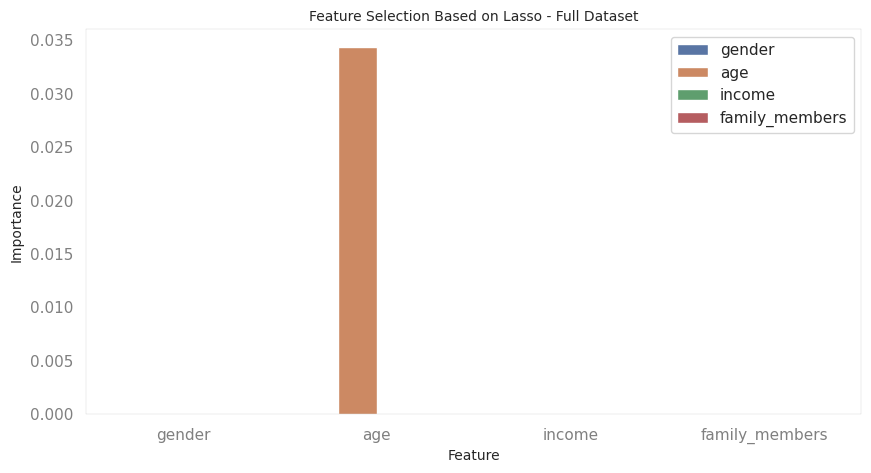

In [14]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize = (10,5))

features_lasso = df.drop('insurance_benefits', axis=1)
target_lasso = df.insurance_benefits
names = df.drop('insurance_benefits', axis=1).columns

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(features_lasso, target_lasso).coef_

sns.barplot(x=names, y=lasso_coef, hue=names, ax=ax)

plt.title('Feature Selection Based on Lasso - Full Dataset', fontsize=10)
ax.set_xlabel('Feature', fontsize=10)
ax.set_ylabel('Importance',fontsize=10)

ax.tick_params(color='gray', labelcolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('gray')


plt.xticks(rotation=0)
plt.show()

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(metric=metric).fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)
df_scaled = df_scaled.drop('insurance_benefits', axis=1)

In [19]:
df_not_scaled = df.copy()
df_not_scaled.loc[:, feature_names] = df[feature_names].to_numpy()
df_not_scaled = df_not_scaled.drop('insurance_benefits', axis=1)

Now, let's get similar records for a given one for every combination

In [20]:
print('Scaled dataset - Euclidean Distance')
display(get_knn(df_scaled, 10, 100, 'euclidean'))

Scaled dataset - Euclidean Distance


,gender,age,income,family_members,distance
10,1.0,0.384615,0.463291,0.166667,0.000000
4377,1.0,0.384615,0.473418,0.166667,0.010127
1389,1.0,0.369231,0.464557,0.166667,0.015437
760,1.0,0.369231,0.462025,0.166667,0.015437
2254,1.0,0.400000,0.455696,0.166667,0.017157
...,...,...,...,...,...
3681,1.0,0.415385,0.520253,0.166667,0.064741
2359,1.0,0.353846,0.406329,0.166667,0.064741
2754,1.0,0.430769,0.417722,0.166667,0.064860
2104,1.0,0.323077,0.439241,0.166667,0.066071


In [21]:
print('No scaling dataset - Euclidean Distance')
display(get_knn(df_not_scaled, 10, 100, 'euclidean'))

No scaling dataset - Euclidean Distance


,gender,age,income,family_members,distance
10,1.0,25.0,36600.0,1.0,0.000000
4039,1.0,25.0,36600.0,2.0,1.000000
3247,1.0,26.0,36600.0,2.0,1.414214
2037,1.0,26.0,36600.0,0.0,1.414214
1508,0.0,26.0,36600.0,0.0,1.732051
...,...,...,...,...,...
426,0.0,23.0,36900.0,1.0,300.008333
3122,0.0,27.0,36300.0,0.0,300.010000
303,1.0,28.0,36900.0,1.0,300.015000
4303,1.0,26.0,36900.0,4.0,300.016666


In [22]:
print('Scaled dataset - Manhattan Distance')
display(get_knn(df_scaled, 10, 20, 'manhattan'))

Scaled dataset - Manhattan Distance


,gender,age,income,family_members,distance
10,1.0,0.384615,0.463291,0.166667,0.000000
4377,1.0,0.384615,0.473418,0.166667,0.010127
1389,1.0,0.369231,0.464557,0.166667,0.016650
760,1.0,0.369231,0.462025,0.166667,0.016650
2254,1.0,0.400000,0.455696,0.166667,0.022980
26,1.0,0.384615,0.437975,0.166667,0.025316
3261,1.0,0.400000,0.473418,0.166667,0.025511
4241,1.0,0.369231,0.446835,0.166667,0.031840
4201,1.0,0.400000,0.446835,0.166667,0.031840
4128,1.0,0.384615,0.430380,0.166667,0.032911


In [23]:
print('No scaling dataset - Manhattan Distance')
display(get_knn(df_not_scaled, 10, 20, 'manhattan'))

No scaling dataset - Manhattan Distance


,gender,age,income,family_members,distance
10,1.0,25.0,36600.0,1.0,0.0
4039,1.0,25.0,36600.0,2.0,1.0
2037,1.0,26.0,36600.0,0.0,2.0
3247,1.0,26.0,36600.0,2.0,2.0
1508,0.0,26.0,36600.0,0.0,3.0
1949,0.0,24.0,36600.0,0.0,3.0
1573,0.0,27.0,36600.0,2.0,4.0
2890,0.0,23.0,36600.0,0.0,4.0
49,0.0,28.0,36600.0,1.0,4.0
4797,1.0,29.0,36600.0,2.0,5.0


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

It influences the results. In the case of non-scaled data, the distance measurements are excessively 'dispersed' due to the differing magnitudes in both the age and income columns (this becomes particularly evident when increasing k to +100 and observing a broader range of the table). Additionally, we observe varying neighboring customers because the data is not scaled and/or the features do not accurately represent each other.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

When examining the two tables that utilize Manhattan distance, we observe some similarities in the distance measurements. However, the neighboring lists vary between them. For instance, in the scaled data, there is a greater prevalence of gender=1 near our n object, which is 10, compared to the evaluation without scaling. This disparity becomes more pronounced as k increases.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [24]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'] > 0
#print(df['insurance_benefits_received'])

insurance_benefits = df['insurance_benefits_received'].values
#print(insurance_benefits)

insurance_benefits_all = df.query("insurance_benefits_received > 0").values
#print(insurance_benefits_all)

<AxesSubplot:title={'center':'count (target)'}>

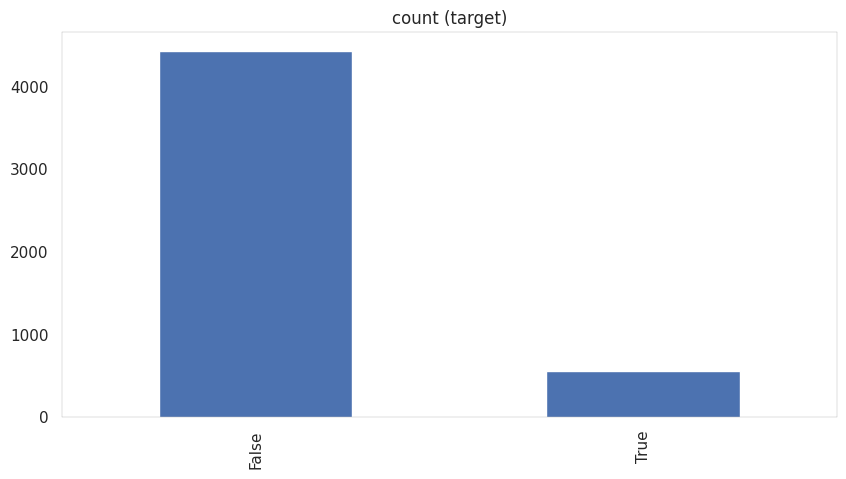

In [25]:
# check for the class imbalance with value_counts()

sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize = (10,5))

df['insurance_benefits_received'].value_counts().plot(kind='bar', title='count (target)')

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [27]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(insurance_benefits), seed=42) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [29]:
# orig. data

y_orig = df['insurance_benefits'].to_numpy()
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=12345)

for n in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    prediction_test = knn.predict(X_test)
    eval_classifier(y_test, prediction_test)
    print('')

F1: 0.61
Confusion Matrix
[[0.87       0.02133333]
 [0.052      0.05666667]]

F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]

F1: 0.41
Confusion Matrix
[[0.88       0.01133333]
 [0.078      0.03066667]]

F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]

F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]

F1: 0.11
Confusion Matrix
[[0.89       0.00133333]
 [0.102      0.00666667]]

F1: 0.11
Confusion Matrix
[[0.88866667 0.00266667]
 [0.102      0.00666667]]

F1: 0.07
Confusion Matrix
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]

F1: 0.08
Confusion Matrix
[[0.89133333 0.        ]
 [0.104      0.00466667]]

F1: 0.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.10866667 0.        ]]



In [30]:
# scaled data (df_scaled)

features_train, features_test, target_train, target_test = train_test_split(X,
                                                                            y, 
                                                                            test_size=0.3, 
                                                                            random_state=12345)
scaler = MaxAbsScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

for n in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(features_train, target_train)
    prediction_test = knn.predict(features_test)
    eval_classifier(target_test, prediction_test)
    print('')

F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]

F1: 0.92
Confusion Matrix
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]

F1: 0.90
Confusion Matrix
[[0.89       0.00133333]
 [0.018      0.09066667]]

F1: 0.92
Confusion Matrix
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]

F1: 0.90
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]

F1: 0.92
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]

F1: 0.88
Confusion Matrix
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]





Construct a classifier utilizing the K-nearest neighbors (KNN) algorithm and assess its performance using the F1 metric for values of k ranging from 1 to 10, applied to both the original dataset and the scaled version. It would be intriguing to observe how varying k affects the evaluation metric, as well as to determine if scaling the data produces any significant impact.

The effect of scaling is significant in this context. When examining scaled data and as the value of K rises, the F1 score experiences a slight decline; however, it begins from a considerably higher initial point compared to the unscaled or original dataset, where the F1 score initiates at 0.61 and swiftly approaches zero. Overall, scaled data demonstrates consistently superior performance across all iterations of K.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [31]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [32]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

Initial/Base Data

In [33]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


Scaled Data - MaxAbsScaler()

In [34]:
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(df_scaled, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(scaled_X_train, scaled_y_train)
print('lr weights:', lr.weights)
print('')
scaled_y_test_pred = lr.predict(scaled_X_test)
eval_regressor(scaled_y_test, scaled_y_test_pred)

lr weights: [-0.94353901  0.01642727  2.32372069 -0.02059875 -0.07014128]

RMSE: 0.34
R2: 0.66


<b> Can you see any difference in RMSE between these two cases? </b>

Based on our observations, the RMSE values remain consistent regardless of variations in weights. However, scaling could influence linear regression outcomes when utilizing L1/L2 regularization or when the model is trained through stochastic gradient descent.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
display(df_pn)

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


In [36]:
X = df_pn.to_numpy()
print(X)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


Generating a random matrix $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [38]:
print('X @ P - Transformed Matrix\n')
transformation = X @ P
print(transformation)

print('')
print('P Inverse\n')
P_inverse = np.linalg.inv(P)
print(P)
print('')

X @ P - Transformed Matrix

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

P Inverse

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]



<b> Can you guess the customers' ages or income after the transformation? </b>

It is impossible to accurately determine a customer's age or income based solely on the information available. Nevertheless, one can observe some trends and general patterns within those two specific columns. These trends tend to align with the structure and characteristics of the initial dataset, exhibiting behavior that is quite comparable to that of the original data. This suggests that while exact figures remain elusive, there are still discernible indicators that reflect similar tendencies as found in the primary dataset.

In [39]:
display(df_pn)
display(pd.DataFrame(transformation, columns=personal_info_column_list))

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380
4996,6717.000247,23634.217067,19456.138634,48589.438841
4997,4346.223425,15289.241265,12586.162644,31433.508886
4998,4194.093242,14751.991024,12144.029306,30323.887634


<b> Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here. </b>

Assuming that this data recovery is accomplished by multiplying the altered data with the inverse of P.

In [40]:
# 𝑋′ is the transpose matrix

print('Recovered\n')
recovered = transformation.dot(P_inverse)
print(recovered)
print('')

Recovered

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]



Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
print('The original data:')
display(pd.DataFrame(X, columns=personal_info_column_list).head(3))

print('')
print('The transformed one:')
display(pd.DataFrame(transformation, columns=personal_info_column_list).head(3))

print('')
print('The reversed (recovered) one:')
display(pd.DataFrame(recovered, columns=personal_info_column_list).head(3))
print('')

The original data:


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0



The transformed one:


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631



The reversed (recovered) one:


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13


<b> You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that? </b>

One might infer that it results from the general procedure of obscuring the data, such as using floating-point numbers during the conversion from integers.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

<b> How would 𝑤 and 𝑤𝑃 be linked if you simplify the formula for 𝑤𝑃 above? </b>

Based off of the condensed/manipulated result: $$ w_P = P^{-1} .w $$

What would be predicted values with 𝑤𝑃?

Same as the values before the obsfucation. We can get back to the original formula using the multiplicative identity property:

<table>
<tr>
<td>replacing 𝑤 with 𝑤𝑃:</td><td>$\hat{y_P} = X_{val}P \cdot w_P$</td>
</tr>    
<tr>
<td>Multiplicative identity:</td><td>$\hat{y_P} = X_{val}P \cdot P^{-1}w$</td>
</tr>    
<tr>
<td>Multiplicative identity:</td><td>$\hat{y_P} = X_{val} P \cdot I \cdot w$</td>
</tr>    
<tr>
<td>Multiplicative identity:</td><td>$\hat{y_P} = X_{val}w$</td>
</tr>    
<tr>
<td>$\hat{y_P} = \hat{y}$</td>
</tr> 
</table>	

<b> What does that mean for the quality of linear regression if you measure it with RMSE? </b>

RMSE is not expected to change given equality.


**Analytical proof**

Formula is condesed as things get removed or cancelled out (one by one; manupulation)
Masking does not affect linear regression itself

<table>
<tr>
<td>$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$</td>
</tr>    
<tr>
<td>Reversivity:</td><td>$$w_P = [(P^TX^T XP]^{-1} \cdot P^TX^T \cdot y$$</td>
</tr>
<tr>
<td>Associative property:</td><td>$$w_P = [(P^T(X^TX)P]^{-1} P^TX^T y$$</td>
</tr>
<tr>
<td>Multiplicative identity:</td><td>$$w_P = P^{-1}(X^TX)^{-1}(P^{-1}) P^TX^T y$$</td>
</tr>
<tr>
<td>Associative property:</td><td>$$w_P = P^{-1}(X^TX)^{-1}[(P^{-1}) \cdot P^T]X^T y$$</td>
</tr>
<tr>
<td>Multiplicative identity:</td><td>$$w_P = P^{-1}(X^TX)^{-1}I \cdot X^T y$$</td>
</tr>
<tr>
<td>$$w_P = P^{-1}(X^TX)^{-1}X^T \cdot y$$</td>
</tr>
<tr>
<td>$$w_P = P^{-1}\cdot w$$</td>
</tr>
</table>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [42]:
# original data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test) # metrics were similar leveraging the training dataset
eval_regressor(y_test, y_test_pred) # metrics were similar leveraging the training dataset

RMSE: 0.34
R2: 0.66


Checking feature importance

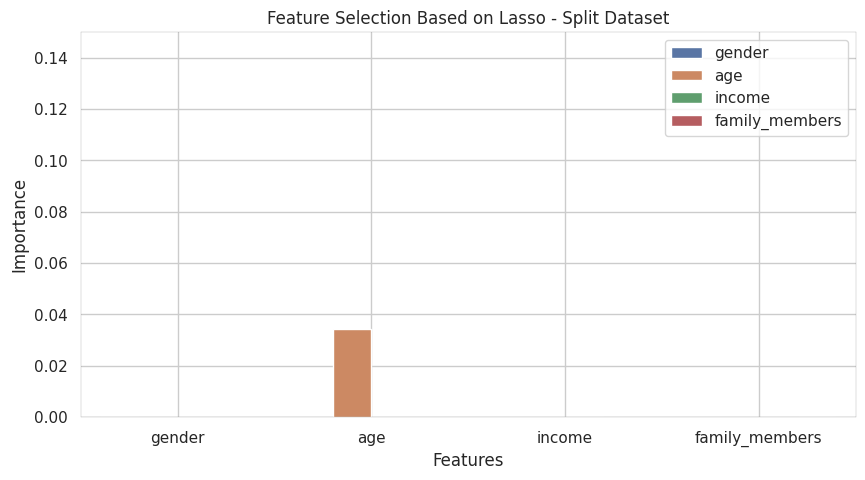

In [43]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize = (10,5))

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.1)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
sns.barplot(x=names, y=lasso1_coef, hue=names)
plt.xticks(rotation=0)
plt.grid()
plt.title("Feature Selection Based on Lasso - Split Dataset")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [44]:
# obfuscation transformation

X_train, X_test, y_train, y_test = train_test_split(transformation, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test) # metrics were similar leveraging the training dataset
eval_regressor(y_test, y_test_pred) # metrics were similar leveraging the training dataset

RMSE: 0.34
R2: 0.66


# Conclusions

<b> "Adjusting and correcting disparities - enhancing output following the normalization or standardization of features." </b>

The analysis reveals the impact of unscaled data on distance value outcomes. When features exhibit greater variability or magnitude, the resulting distance outputs become increasingly dispersed, a trend that is more pronounced when we increase k beyond 100. Additionally, by applying the same distance measurement to both scaled and unscaled data, we can observe the actual differences in output and gain insight into the extent of variability present.

Scaling significantly impacts scores. In the case of scaled data, as K rises, we observe declines in the F1 score compared to the non-scaled or original dataset, which begins at a higher level overall. With our non-scaled data, the F1 score starts at 0.61 and swiftly drops to zero by the 10th iteration of K. In contrast, the scaled data remains relatively stable across the same number of K iterations, consistently around the 0.90 mark after 10 iterations.

<b> "Data masking - demonstrating that concealing our data can be effective with linear regression models without impacting specific results." </b>

During our transformation process, we determined that there is sufficient evidence (both qualitative and quantitative) indicating that data masking does not influence our RMSE metrics within this particular modeling scenario and specific parameters. However, if our transformation matrix is accessible, it is probable that the original data could be partially reconstructed or retrieved, although it will never be possible to completely ascertain the original dataset.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>